# First steps:
- create datajoint config file
- enter credentials in the config file (dj_local_conf.json)
- if you want to access the raw tiff files, you have to specify the location of the movies, where you put the Data folder
- place config file in the working directory
# the config file (dj_local_conf.json) :
{<br>
  "connection.init_function": null,<br>
  "database.host": "mesoscale-activity.datajoint.io",<br>
  "database.password": "-------------------------------------password-comes-here--",<br>
  "database.port": 3306,<br>
  "database.reconnect": false,<br>
  "database.user": "-----------------------------------------username comes here --",<br>
  "display.limit": 7,<br>
  "display.show_tuple_count": true,<br>
  "display.width": 14,<br>
  "do_unittest": true,<br>
  "enable_python_native_blobs": true,<br>
  "external.aws_access_key_id": null,<br>
  "external.aws_secret_access_key": null,<br>
  "external.location": null,<br>
  "history": [],<br>
  "locations.mr_share": "------------------------------------location of the Data folder files comes here - if you want to access the raw movies",<br>
  "loglevel": "INFO",<br>
  "metadata.notebook_name": "Genie Calcium Imaging",<br>
  "project": "GENIE Calcium Imaging",<br>
  "safemode": true<br>
}

In [1]:
# make sure that the working directory is the root directory of this repo, where the config file is
%cd '/home/rozmar/Scripts/Python/2P_cellAttached_pipeline/'
import datajoint as dj
dj.conn() # if you are requested to give a username then you forgot to add the config file

/home/rozmar/Scripts/Python/2P_cellAttached_pipeline
Connecting rozmar@mesoscale-activity.datajoint.io:3306


DataJoint connection (connected) rozmar@mesoscale-activity.datajoint.io:3306

This is the desired output:<br>
```DataJoint connection (connected) < username >@mesoscale-activity.datajoint.io:3306```
<br><br>
If the connection is lost (due to inactivity or network issues) use ```dj.conn().connect()``` to reconnect. You can also catch the error and reconnect.
<br>
If you want to make sure the connection stays alive during a long script, use ```dj.conn().ping()``` every 10-30 minutes (or more frequently) in your scripts.

In [2]:
# let's import the scemas, you need to import only the ones that you use, but you can import all of them at once
from pipeline import lab # lab schema contains the experimenters, subjects, surgeries, viruses, rigs
from pipeline import experiment # experiment schema contains the sessions, behavior, it's not fully populated yet
from pipeline import ephys_cell_attached  # ephys_cell_attached schema contains the raw cell attached data
from pipeline import ephysanal_cell_attached # ephysanal_cell_attached schema contains everything that is calculated from ephys_cell_attached like action potentials..
from pipeline import imaging # imaging schema contains the raw data and metadata for imaging, file locations etc
from pipeline import imaging_gt # imaging_gt schema connects ephys and imaging and has some more useful tables

import matplotlib.pyplot as plt #
%matplotlib inline
import numpy as np

# Subject, session, sensor:

In [3]:
#
# you can inspect each table just by calling it, for example, all the Subjects that we used can be listed:
lab.Subject()

subject_id institution 6 digit animal ID,username,cage_number institution 6 digit animal ID,date_of_birth format: yyyy-mm-dd,sex,animal_source
471991,liangy10,176870,2019-11-26,M,None
471993,liangy10,176870,2019-11-26,M,None
471994,liangy10,176870,2019-11-26,M,None
471996,liangy10,176871,2019-11-20,M,None
471997,liangy10,176871,2019-11-20,M,None
471999,liangy10,176871,2019-11-20,M,None
472001,liangy10,176872,2019-11-26,M,None


In [4]:
# One session is the data from one subject from one day. In this dataset all subjects have a single session
# because it's a terminal experiment
# Note that there are fewer sessions than subjects, because not all subjects could be used for experiment
experiment.Session()

subject_id institution 6 digit animal ID,session session number,session_date,session_time,username,rig
471991,1,2020-05-07,20:30:36,rozsam,Genie-2p-Resonant-MIMMS
471993,1,2020-05-08,0:02:29,rozsam,Genie-2p-Resonant-MIMMS
471994,1,2020-05-09,18:25:40,rozsam,Genie-2p-Resonant-MIMMS
471996,1,2020-04-16,20:45:53,rozsam,Genie-2p-Resonant-MIMMS
471997,1,2020-04-18,17:27:59,rozsam,Genie-2p-Resonant-MIMMS
472001,1,2020-04-17,19:29:13,rozsam,Genie-2p-Resonant-MIMMS
472002,1,2020-03-10,17:36:43,rozsam,Genie-2p-Resonant-MIMMS


In [5]:
# each table has primary keys that define eacg entry in the table (* before the key or bold black name in Jupyter)
# for example a session is defined by a subject and a session number
experiment.Session()&'subject_id = 471997'&'session = 1' # returns a single session

subject_id institution 6 digit animal ID,session session number,session_date,session_time,username,rig
471997,1,2020-04-18,17:27:59,rozsam,Genie-2p-Resonant-MIMMS


In [6]:
# The different sensors can be retrieved from the following table:
imaging_gt.SessionCalciumSensor()

subject_id institution 6 digit animal ID,session session number,session_calcium_sensor,session_virus_name,session_sensor_expression_time expression time in days,session_sensor_max_titer,session_sensor_min_titer,session_age age of mouse at experiment
471991,1,GCaMP7F,pGP-AAV-syn-WPRE-GCaMP3 T302L R303P A317L D380Y.4.921,60,4000000000000.0,4000000000000.0,103
471993,1,456,pGP-AAV-syn-6xHis-noRSET-1NIW_Q315L_N19T_S24I_S26R_Q88E_LKI_GCaMP6s-WPRE.547.456,61,4075000000000.0,4075000000000.0,103
471994,1,456,pGP-AAV-syn-6xHis-noRSET-1NIW_Q315L_N19T_S24I_S26R_Q88E_LKI_GCaMP6s-WPRE.547.456,62,4075000000000.0,4075000000000.0,103
471996,1,XCaMPgf,pGP-AAV-syn-NES-XCaMP-Gf-WPRE.538.1,73,983333333333.3334,3933333333333.3335,75
471997,1,456,pGP-AAV-syn-6xHis-noRSET-1NIW_Q315L_N19T_S24I_S26R_Q88E_LKI_GCaMP6s-WPRE.547.456,73,1018750000000.0,4075000000000.0,77
472001,1,GCaMP7F,pGP-AAV-syn-WPRE-GCaMP3 T302L R303P A317L D380Y.4.921,77,2000000000000.0,2000000000000.0,66
472002,1,XCaMPgf,pGP-AAV-syn-NES-XCaMP-Gf-WPRE.538.1,39,983333333333.3334,3933333333333.3335,66


In [7]:
# collect the name of the calcium sensors so we can use it as reference in the future:
sensors = np.unique(imaging_gt.SessionCalciumSensor().fetch('session_calcium_sensor'))
print('the sensor names are: {}'.format(sensors))

the sensor names are: ['456' '686' '688' 'GCaMP7F' 'XCaMPgf']


In [8]:
# you can restrict the tables to the sensor similarly as above
sensor_needed = sensors[0]
imaging_gt.SessionCalciumSensor()&'session_calcium_sensor = "{}"'.format(sensor_needed)

subject_id institution 6 digit animal ID,session session number,session_calcium_sensor,session_virus_name,session_sensor_expression_time expression time in days,session_sensor_max_titer,session_sensor_min_titer,session_age age of mouse at experiment
471993,1,456,pGP-AAV-syn-6xHis-noRSET-1NIW_Q315L_N19T_S24I_S26R_Q88E_LKI_GCaMP6s-WPRE.547.456,61,4075000000000.0,4075000000000.0,103
471994,1,456,pGP-AAV-syn-6xHis-noRSET-1NIW_Q315L_N19T_S24I_S26R_Q88E_LKI_GCaMP6s-WPRE.547.456,62,4075000000000.0,4075000000000.0,103
471997,1,456,pGP-AAV-syn-6xHis-noRSET-1NIW_Q315L_N19T_S24I_S26R_Q88E_LKI_GCaMP6s-WPRE.547.456,73,1018750000000.0,4075000000000.0,77
478342,1,456,pGP-AAV-syn-6xHis-noRSET-1NIW_Q315L_N19T_S24I_S26R_Q88E_LKI_GCaMP6s-WPRE.547.456,20,4075000000000.0,4075000000000.0,52
478348,1,456,pGP-AAV-syn-6xHis-noRSET-1NIW_Q315L_N19T_S24I_S26R_Q88E_LKI_GCaMP6s-WPRE.547.456,14,4075000000000.0,4075000000000.0,52
478349,1,456,pGP-AAV-syn-6xHis-noRSET-1NIW_Q315L_N19T_S24I_S26R_Q88E_LKI_GCaMP6s-WPRE.547.456,17,4075000000000.0,4075000000000.0,52
478407,1,456,pGP-AAV-syn-6xHis-noRSET-1NIW_Q315L_N19T_S24I_S26R_Q88E_LKI_GCaMP6s-WPRE.547.456,18,4075000000000.0,4075000000000.0,53


# Movies, motion correction, ROIs

In [9]:
# The experiments are built up of movies, a movie is around 3 minutes long
imaging.Movie() # there are 1333 movies currently, this table contains only metadata

subject_id institution 6 digit animal ID,session session number,movie_number,movie_name movie name,movie_x_size (pixels),movie_y_size (pixels),movie_frame_rate (Hz),movie_frame_num number of frames,movie_start_time (s) from session start # maybe end_time would also be useful,movie_pixel_size in microns
471991,1,0,cell1_stim01_00001,512.0,128.0,121.997,19520,0.000040,0.31
471991,1,1,cell1_stim02_00001,512.0,128.0,121.997,19520,196.576060,0.31
471991,1,2,cell1_stim03_00001,512.0,128.0,121.997,19520,392.652059,0.31
471991,1,3,cell1_stim04_00001,512.0,128.0,121.997,19520,599.364119,0.31
471991,1,4,cell1_stim05_00001,512.0,128.0,121.997,19520,815.630140,0.31
471991,1,5,cell2_stim01_00002,256.0,128.0,121.997,19520,1502.000060,0.62
471991,1,6,cell2_stim02_00001,256.0,128.0,121.997,19520,1685.881080,0.62


In [10]:
# the timing of each frame is stored in the imaging.MovieFrameTimes() table
imaging.MovieFrameTimes()

subject_id institution 6 digit animal ID,session session number,movie_number,frame_times timing of each frame relative to Session start - frame start time
471991,1,0,=BLOB=
471991,1,1,=BLOB=
471991,1,2,=BLOB=
471991,1,3,=BLOB=
471991,1,4,=BLOB=
471991,1,5,=BLOB=
471991,1,6,=BLOB=


In [11]:
# you can take a look at the table definition if you are not sure what frame_times mean:
imaging.MovieFrameTimes().heading # it's not documented properly everywhere, please ask questions if not clear

# 
subject_id           : int                          # institution 6 digit animal ID
session              : smallint                     # session number
movie_number         : smallint                     # 
---
frame_times          : longblob                     # timing of each frame relative to Session start - frame start time

In [12]:
# if you want the metadata and the frame times in the same table, you can easily concatenate them
imaging.Movie()*imaging.MovieFrameTimes()
# this is the magic of datajoint, it will be very useful  when we have more tables

subject_id institution 6 digit animal ID,session session number,movie_number,movie_name movie name,movie_x_size (pixels),movie_y_size (pixels),movie_frame_rate (Hz),movie_frame_num number of frames,movie_start_time (s) from session start # maybe end_time would also be useful,movie_pixel_size in microns,frame_times timing of each frame relative to Session start - frame start time
471991,1,0,cell1_stim01_00001,512.0,128.0,121.997,19520,0.000040,0.31,=BLOB=
471991,1,1,cell1_stim02_00001,512.0,128.0,121.997,19520,196.576060,0.31,=BLOB=
471991,1,2,cell1_stim03_00001,512.0,128.0,121.997,19520,392.652059,0.31,=BLOB=
471991,1,3,cell1_stim04_00001,512.0,128.0,121.997,19520,599.364119,0.31,=BLOB=
471991,1,4,cell1_stim05_00001,512.0,128.0,121.997,19520,815.630140,0.31,=BLOB=
471991,1,5,cell2_stim01_00002,256.0,128.0,121.997,19520,1502.000060,0.62,=BLOB=
471991,1,6,cell2_stim02_00001,256.0,128.0,121.997,19520,1685.881080,0.62,=BLOB=


In [13]:
# Each movie is motion corrected, then the ROIs and neuropil is segmented. We have the opportunity to use
# different motion corrections and ROI segmentations for the same movie, right now we only have "Suite2P"
# motion correction and "Suite2P" ROI segmentation
imaging.ROI() # this table also contains only metadata, there are around 10000 ROIs (not all of them are ground truth ROIs)

subject_id institution 6 digit animal ID,session session number,movie_number,motion_correction_method,roi_type,"roi_number roi number (restarts for every registered movie, same number in different channels means the same ROI)","roi_centroid_x ROI centroid x, pixels","roi_centroid_y ROI centroid y, pixels",roi_xpix pixel mask,roi_ypix pixel mask,roi_pixel_num,roi_weights weight of each pixel,roi_time_offset time offset of ROI relative to frame time,roi_aspect_ratio,roi_compact,roi_radius,roi_skew
471991,1,0,Suite2P,Suite2P,0,85.5,37.5,=BLOB=,=BLOB=,738,=BLOB=,0.00236449125,1.0970462640392478,1.2733050599744058,19.81550752018795,2.3121457
471991,1,0,Suite2P,Suite2P,3,188.0,49.0,=BLOB=,=BLOB=,693,=BLOB=,0.0030896019,1.052395721433304,1.672296101353203,24.460856592433217,4.447649
471991,1,0,Suite2P,Suite2P,66,265.0,27.0,=BLOB=,=BLOB=,337,=BLOB=,0.0017024337,1.3472255074480197,1.8863317064710707,25.14850892529665,1.1191263
471991,1,1,Suite2P,Suite2P,0,86.0,40.0,=BLOB=,=BLOB=,667,=BLOB=,0.002522124,1.1421899833421714,1.2891324687732826,20.031001913854283,2.6261108
471991,1,1,Suite2P,Suite2P,2,187.0,50.0,=BLOB=,=BLOB=,699,=BLOB=,0.003152655,1.1481766393627562,1.4614976909133162,22.719538983467615,7.047305
471991,1,1,Suite2P,Suite2P,68,263.0,30.0,=BLOB=,=BLOB=,316,=BLOB=,0.001891593,1.4569916165272712,1.6532062056298373,22.662507103786528,0.9279245
471991,1,2,Suite2P,Suite2P,0,184.0,52.0,=BLOB=,=BLOB=,745,=BLOB=,0.0032787612,1.2214567459769545,1.4655271727893058,24.31470274237718,8.667972


In [14]:
# right now not necessary, but a good practice to always restrict to motion_correction_method and roi_type,
# since we might have more of these in the future:
imaging.ROI()&'motion_correction_method = "Suite2P"'&'roi_type = "Suite2P"' 
# it gives the same result as this is all that we have right now

subject_id institution 6 digit animal ID,session session number,movie_number,motion_correction_method,roi_type,"roi_number roi number (restarts for every registered movie, same number in different channels means the same ROI)","roi_centroid_x ROI centroid x, pixels","roi_centroid_y ROI centroid y, pixels",roi_xpix pixel mask,roi_ypix pixel mask,roi_pixel_num,roi_weights weight of each pixel,roi_time_offset time offset of ROI relative to frame time,roi_aspect_ratio,roi_compact,roi_radius,roi_skew
471991,1,0,Suite2P,Suite2P,0,85.5,37.5,=BLOB=,=BLOB=,738,=BLOB=,0.00236449125,1.0970462640392478,1.2733050599744058,19.81550752018795,2.3121457
471991,1,0,Suite2P,Suite2P,3,188.0,49.0,=BLOB=,=BLOB=,693,=BLOB=,0.0030896019,1.052395721433304,1.672296101353203,24.460856592433217,4.447649
471991,1,0,Suite2P,Suite2P,66,265.0,27.0,=BLOB=,=BLOB=,337,=BLOB=,0.0017024337,1.3472255074480197,1.8863317064710707,25.14850892529665,1.1191263
471991,1,1,Suite2P,Suite2P,0,86.0,40.0,=BLOB=,=BLOB=,667,=BLOB=,0.002522124,1.1421899833421714,1.2891324687732826,20.031001913854283,2.6261108
471991,1,1,Suite2P,Suite2P,2,187.0,50.0,=BLOB=,=BLOB=,699,=BLOB=,0.003152655,1.1481766393627562,1.4614976909133162,22.719538983467615,7.047305
471991,1,1,Suite2P,Suite2P,68,263.0,30.0,=BLOB=,=BLOB=,316,=BLOB=,0.001891593,1.4569916165272712,1.6532062056298373,22.662507103786528,0.9279245
471991,1,2,Suite2P,Suite2P,0,184.0,52.0,=BLOB=,=BLOB=,745,=BLOB=,0.0032787612,1.2214567459769545,1.4655271727893058,24.31470274237718,8.667972


In [15]:
# the fluorescence traces are in the imaging.ROITrace() table
imaging.ROITrace() # note that there are twice as many traces as ROIs, because there are 2 channels recorded
# channel 1 is the functional green channel, channel 2 is only for targeting the cell with the electrode

subject_id institution 6 digit animal ID,session session number,movie_number,motion_correction_method,roi_type,"roi_number roi number (restarts for every registered movie, same number in different channels means the same ROI)",channel_number,roi_f,roi_f_mean,roi_f_median,roi_f_min,roi_f_max
471991,1,0,Suite2P,Suite2P,0,1,=BLOB=,151.96385,138.71677,95.472855,415.9208
471991,1,0,Suite2P,Suite2P,0,2,=BLOB=,47.174904,47.022083,27.93631,72.404335
471991,1,0,Suite2P,Suite2P,3,1,=BLOB=,231.0916,229.60802,180.74092,490.62555
471991,1,0,Suite2P,Suite2P,3,2,=BLOB=,57.642796,57.351067,29.980427,84.60121
471991,1,0,Suite2P,Suite2P,66,1,=BLOB=,91.44947,90.255516,52.016815,217.29652
471991,1,0,Suite2P,Suite2P,66,2,=BLOB=,38.13418,37.844463,17.130203,71.111465
471991,1,1,Suite2P,Suite2P,0,1,=BLOB=,139.71628,130.55334,88.516655,375.5434


In [16]:
# let's download a ROI with its timing, now use a dictionary for restriction
key_roi = {'subject_id': 471991,
           'session':1,
           'movie_number':1,
           'motion_correction_method':"Suite2P",
           'roi_type':"Suite2P",
           'roi_number':0,
           'channel_number':1}
# Now we will download everything in one go. We make a giant concatenated table and we fetch the data from that.
# We could do it from each table separately, if we like.

big_table = imaging.MovieFrameTimes()*imaging.ROI()*imaging.ROITrace()
big_table

subject_id institution 6 digit animal ID,session session number,movie_number,motion_correction_method,roi_type,"roi_number roi number (restarts for every registered movie, same number in different channels means the same ROI)",channel_number,frame_times timing of each frame relative to Session start - frame start time,"roi_centroid_x ROI centroid x, pixels","roi_centroid_y ROI centroid y, pixels",roi_xpix pixel mask,roi_ypix pixel mask,roi_pixel_num,roi_weights weight of each pixel,roi_time_offset time offset of ROI relative to frame time,roi_aspect_ratio,roi_compact,roi_radius,roi_skew,roi_f,roi_f_mean,roi_f_median,roi_f_min,roi_f_max
471991,1,0,Suite2P,Suite2P,0,1,=BLOB=,85.5,37.5,=BLOB=,=BLOB=,738,=BLOB=,0.00236449125,1.0970462640392478,1.2733050599744058,19.81550752018795,2.3121457,=BLOB=,151.96385,138.71677,95.472855,415.9208
471991,1,0,Suite2P,Suite2P,0,2,=BLOB=,85.5,37.5,=BLOB=,=BLOB=,738,=BLOB=,0.00236449125,1.0970462640392478,1.2733050599744058,19.81550752018795,2.3121457,=BLOB=,47.174904,47.022083,27.93631,72.404335
471991,1,0,Suite2P,Suite2P,3,1,=BLOB=,188.0,49.0,=BLOB=,=BLOB=,693,=BLOB=,0.0030896019,1.052395721433304,1.672296101353203,24.460856592433217,4.447649,=BLOB=,231.0916,229.60802,180.74092,490.62555
471991,1,0,Suite2P,Suite2P,3,2,=BLOB=,188.0,49.0,=BLOB=,=BLOB=,693,=BLOB=,0.0030896019,1.052395721433304,1.672296101353203,24.460856592433217,4.447649,=BLOB=,57.642796,57.351067,29.980427,84.60121
471991,1,0,Suite2P,Suite2P,66,1,=BLOB=,265.0,27.0,=BLOB=,=BLOB=,337,=BLOB=,0.0017024337,1.3472255074480197,1.8863317064710707,25.14850892529665,1.1191263,=BLOB=,91.44947,90.255516,52.016815,217.29652
471991,1,0,Suite2P,Suite2P,66,2,=BLOB=,265.0,27.0,=BLOB=,=BLOB=,337,=BLOB=,0.0017024337,1.3472255074480197,1.8863317064710707,25.14850892529665,1.1191263,=BLOB=,38.13418,37.844463,17.130203,71.111465
471991,1,1,Suite2P,Suite2P,0,1,=BLOB=,86.0,40.0,=BLOB=,=BLOB=,667,=BLOB=,0.002522124,1.1421899833421714,1.2891324687732826,20.031001913854283,2.6261108,=BLOB=,139.71628,130.55334,88.516655,375.5434


In [17]:
# restrict the table with the dictionary
big_table &   key_roi         

subject_id institution 6 digit animal ID,session session number,movie_number,motion_correction_method,roi_type,"roi_number roi number (restarts for every registered movie, same number in different channels means the same ROI)",channel_number,frame_times timing of each frame relative to Session start - frame start time,"roi_centroid_x ROI centroid x, pixels","roi_centroid_y ROI centroid y, pixels",roi_xpix pixel mask,roi_ypix pixel mask,roi_pixel_num,roi_weights weight of each pixel,roi_time_offset time offset of ROI relative to frame time,roi_aspect_ratio,roi_compact,roi_radius,roi_skew,roi_f,roi_f_mean,roi_f_median,roi_f_min,roi_f_max
471991,1,1,Suite2P,Suite2P,0,1,=BLOB=,86.0,40.0,=BLOB=,=BLOB=,667,=BLOB=,0.002522124,1.1421899833421714,1.2891324687732826,20.031001913854283,2.6261108,=BLOB=,139.71628,130.55334,88.516655,375.5434


Text(0, 0.5, 'raw pixel intensity')

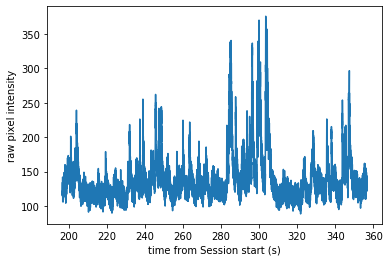

In [18]:
# download the data
frame_times,roi_time_offset,roi_f = (big_table&key_roi).fetch1('frame_times','roi_time_offset','roi_f')
plt.plot(frame_times+roi_time_offset,roi_f)
plt.xlabel('time from Session start (s)')
plt.ylabel('raw pixel intensity')
# note the fetch1() command instead of fetch(). I can use it since 1 have a single entry due to the 
# constraining dictinary. If you use fetch(), you will get lists with single entries.

Text(0, 0.5, 'raw pixel intensity corrected with neuropil')

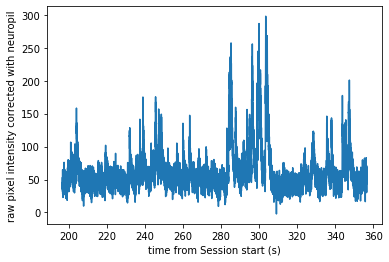

In [19]:
# We have multiple neuropils for each ROI (depending on how many pixels are skipped between the edge of the
# ROI and the start of the neuropil), I suggest using neuropil = 1 (4 pixels big gap)
# let's download the neuropil, too
neuropil_f = (imaging.ROINeuropilTrace() & key_roi & 'neuropil_number = 1').fetch1('neuropil_f')
plt.plot(frame_times+roi_time_offset,roi_f-0.8*neuropil_f)
plt.xlabel('time from Session start (s)')
plt.ylabel('raw pixel intensity corrected with neuropil')

# Electrophysiology, cells, sweeps, action potentials

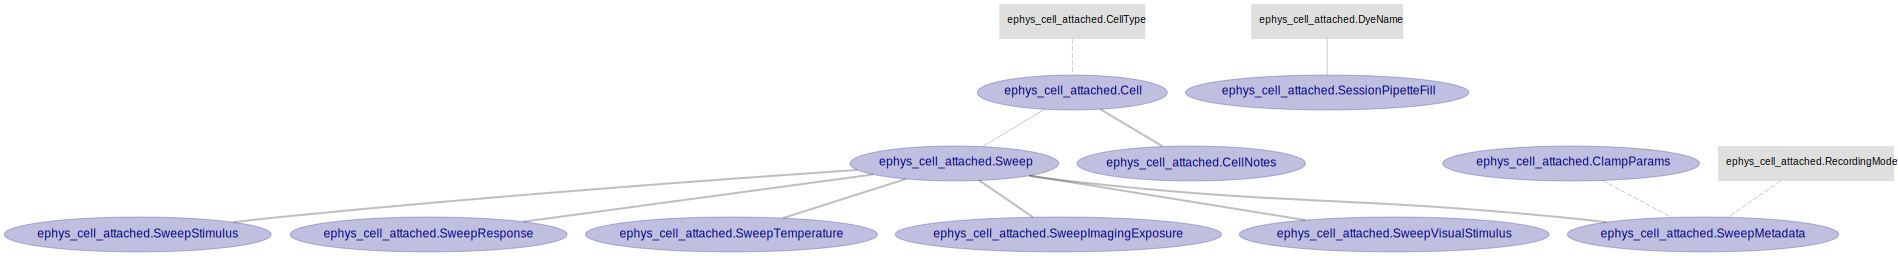

In [20]:
# you can also visualize the schema relationships with erd(), this works best if the schema is more or less
# hierarchical, which is the case with the ephys schema. The unit is a sweep, which corresponds to movies.
# each sweep has different channels (response and stimulus are the only relevants now)

dj.ERD(ephys_cell_attached)

In [21]:
# Sweeps are defined with cell_number and sweep_number
ephys_cell_attached.Sweep() #

subject_id institution 6 digit animal ID,session session number,cell_number,sweep_number,sweep_start_time (s) from recording start,sweep_end_time (s) from recording start,protocol_name,protocol_sweep_number
471991,1,1,0,0.000000,164.244460,cell1_stim01_0001,1
471991,1,1,1,196.576000,360.258960,cell1_stim02_0001,1
471991,1,1,2,392.651999,555.604499,cell1_stim03_0001,1
471991,1,1,3,599.363999,768.890579,cell1_stim04_0001,1
471991,1,1,4,815.630000,983.262180,cell1_stim05_0001,1
471991,1,2,0,0.000000,163.640300,cell2_stim01_0001,1
471991,1,2,1,183.881000,349.419100,cell2_stim02_0001,1


In [22]:
# let's get all the action potentials for a given sweep
key_sweep = {'subject_id': 471991,
             'session':1,
             'cell_number':1,
             'sweep_number':3}
ephysanal_cell_attached.ActionPotential() & key_sweep

subject_id institution 6 digit animal ID,session session number,cell_number,sweep_number,ap_num action potential number in sweep,ap_max_index index of AP max on sweep,ap_max_time time of the AP max relative to recording start,ap_snr_v,ap_snr_dv,ap_halfwidth hw in ms,ap_full_width in ms,ap_rise_time in ms,ap_integral A*s or V*s depending on recording mode,ap_amplitude in A or V depending on recording mode,ap_ahp_amplitude in A or V depending on recording mode,ap_isi s between AP before and this AP - null if first AP in sweep,ap_peak_to_trough_time ms,ap_baseline_current A,ap_baseline_voltage V
471991,1,1,3,1,34189,0.6838,120.14813180898445,33.40187894768509,0.27,0.622,0.174,1.300099035620369e-13,2.503416963141734e-10,6.256624712029782e-11,nan,0.82,-2.3540272772359405e-12,nan
471991,1,1,3,2,220803,4.4161,104.6559788113918,55.32788343395473,0.28200000000000003,0.672,0.214,1.27900852320942e-13,2.364522503979349e-10,6.91908416261502e-11,3.73228,0.86,8.499542262905558e-12,nan
471991,1,1,3,3,234135,4.6827,140.65718788261273,48.94155118815315,0.26,0.61,0.13999999999999999,1.1841168594156652e-13,2.4212505830418187e-10,5.720514462604918e-11,0.26664,0.9,6.526165985904502e-12,nan
471991,1,1,3,4,234452,4.6890,78.08986905035184,37.36892633954965,0.308,0.7080000000000001,0.14200000000000002,1.2053293314867523e-13,2.3103511869190432e-10,4.4848302756815474e-11,0.00634,0.9,8.828438308960282e-12,nan
471991,1,1,3,5,234839,4.6968,90.2429576320323,27.937903439124195,0.302,0.776,0.16199999999999998,1.0361489813686144e-13,2.050388017783871e-10,3.932257982685814e-11,0.00774,1.1,-5.175494730103546e-14,nan
471991,1,1,3,6,235100,4.7020,82.74470464041111,23.668086059760604,0.338,0.796,0.188,8.185601118929086e-14,1.5639612660808513e-10,2.800172050535866e-11,0.00522,1.06,5.210581800489625e-12,nan
471991,1,1,3,7,235462,4.7092,179.61298640608663,54.78099813628832,0.36,0.9440000000000001,0.188,9.033188967369017e-14,1.80430087650998e-10,1.8989180052595364e-11,0.00724,1.14,1.8695319672669688e-11,nan


# Putting it together

In [23]:
# the connection between imaging and ephys is the imaging_gt.ROISweepCorrespondance()
# this table connects the sweeps (and thus the cells) to the ROIs (and thus the movies)
imaging_gt.ROISweepCorrespondance()

subject_id institution 6 digit animal ID,session session number,cell_number,sweep_number,movie_number,motion_correction_method,roi_type,"roi_number roi number (restarts for every registered movie, same number in different channels means the same ROI)"
471991,1,1,0,0,Suite2P,Suite2P,3
471991,1,1,1,1,Suite2P,Suite2P,2
471991,1,1,2,2,Suite2P,Suite2P,0
471991,1,1,3,3,Suite2P,Suite2P,2
471991,1,2,0,5,Suite2P,Suite2P,1
471991,1,2,2,7,Suite2P,Suite2P,0
471991,1,2,3,8,Suite2P,Suite2P,2


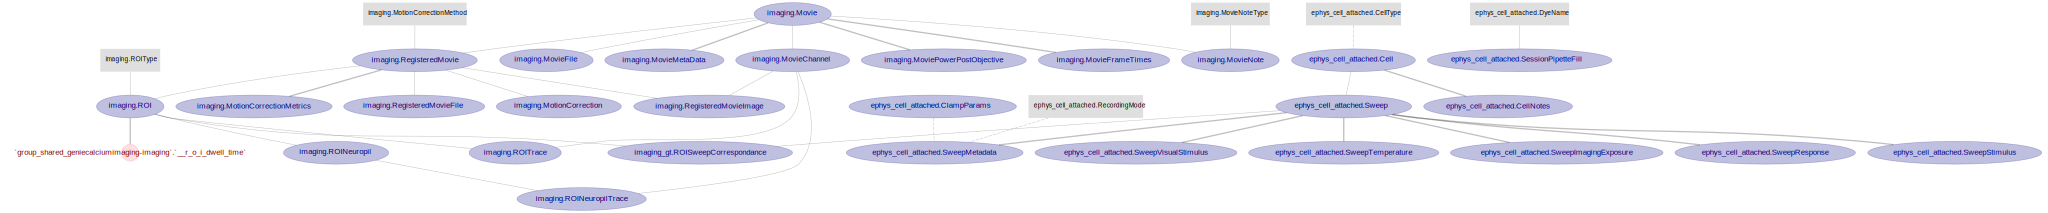

In [24]:
# we can also visualize it ROISweepCorrespondance is the only table that connects the two branches
dj.ERD(ephys_cell_attached)+dj.ERD(imaging)+dj.ERD(imaging_gt.ROISweepCorrespondance)

In [25]:
# let's get the ROI that corresponds to the ephys sweep that we picked earlier
imaging_gt.ROISweepCorrespondance()&key_sweep

subject_id institution 6 digit animal ID,session session number,cell_number,sweep_number,movie_number,motion_correction_method,roi_type,"roi_number roi number (restarts for every registered movie, same number in different channels means the same ROI)"
471991,1,1,3,3,Suite2P,Suite2P,2


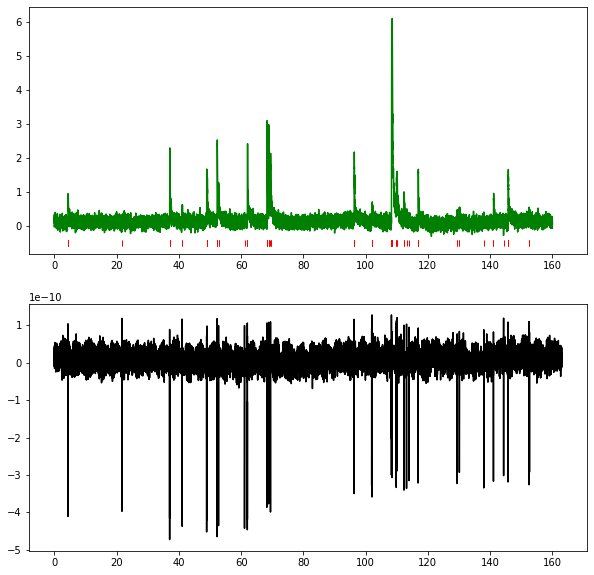

In [26]:
# let's download the ROI, neuropil, frame times, ephys, action potential times for this sweep, 
# and plot them on a single figure
# the electrophysiology time is referenced to the cell, and the movie is referenced to the 
# session start, so we have to take care of this along the way

key = {'subject_id': 471991,# the first first four entries identify a single sweep
       'session':1,
       'cell_number':1,
       'sweep_number':2,   
       'motion_correction_method':"Suite2P",# the second four entries restrict the imaging data (see above)
       'roi_type':"Suite2P",
       'channel_number':1,
       'neuropil_number':1} 

cell_recording_start, session_time = (ephys_cell_attached.Cell()*experiment.Session()&key).fetch1('cell_recording_start', 'session_time')

imaging_table = imaging.MovieFrameTimes()*imaging.ROI()*imaging.ROINeuropilTrace()*imaging.ROITrace()*imaging_gt.ROISweepCorrespondance()
roi_f,neuropil_f,roi_time_offset,frame_times = (imaging_table&key).fetch1('roi_f','neuropil_f','roi_time_offset','frame_times')
frame_times = frame_times+ roi_time_offset      

roi_f_corr = roi_f-neuropil_f*0.8
f0 = np.percentile(roi_f_corr,10)
roi_dff = (roi_f_corr-f0)/f0

sweep_start_time =  (ephys_cell_attached.Sweep()&key).fetch1('sweep_start_time')
response_trace, sample_rate = (ephys_cell_attached.SweepMetadata()*ephys_cell_attached.SweepResponse()&key).fetch1('response_trace','sample_rate')

ephys_time = np.arange(len(response_trace))/sample_rate
frame_times = frame_times - ((cell_recording_start-session_time).total_seconds()+float(sweep_start_time))

ap_max_times,ap_max_indices=(ephysanal_cell_attached.ActionPotential()&key).fetch('ap_max_time','ap_max_index')

fig = plt.figure(figsize = [10,10])
ax_ophys = fig.add_subplot(2,1,1)
ax_ephys = fig.add_subplot(2,1,2,sharex = ax_ophys)
ax_ophys.plot(frame_times,roi_dff,'g-')
ax_ophys.plot(np.asarray(ap_max_times,'float'),np.zeros(len(ap_max_times))-.5,'r|')
ax_ephys.plot(ephys_time,response_trace,'k-')

# QC - getting rid of low quality sweeps

In [27]:
# for each sweep we defined metrics that can help you clean up the data
# This are not final criteria, feel free to come up with new constrains.
# There is a chance that I'll do manual inspection on the traces but that will take a while..

qc_criteria = {'min_sweep_ap_snr_dv_median':10, # don't include traces where the median of AP SNR is below 10
               'max_sweep_ap_hw_std_per_median':0.2, # don't include traces where the variability of spikes is big
               }
sensor_needed = '688' # select a sensor 

ephys_snr_cond = 'sweep_ap_snr_dv_median>={}'.format(qc_criteria['min_sweep_ap_snr_dv_median'])
ephys_hwstd_cond = 'sweep_ap_hw_std_per_median<={}'.format(qc_criteria['max_sweep_ap_hw_std_per_median'])
sensor_cond = 'session_calcium_sensor = "{}"'.format(sensor_needed)

condition_list = [ephys_snr_cond,ephys_hwstd_cond,sensor_cond]


all_ROIs = imaging_gt.ROISweepCorrespondance()*imaging_gt.SessionCalciumSensor()*ephysanal_cell_attached.SweepAPQC()#*imaging_gt.MovieCalciumWaveSNR()
ROIs_constrained = all_ROIs & dj.AndList(condition_list)
ROIs_constrained

subject_id institution 6 digit animal ID,session session number,cell_number,sweep_number,movie_number,motion_correction_method,roi_type,"roi_number roi number (restarts for every registered movie, same number in different channels means the same ROI)",session_calcium_sensor,session_virus_name,session_sensor_expression_time expression time in days,session_sensor_max_titer,session_sensor_min_titer,session_age age of mouse at experiment,sweep_ap_snr_dv_min,sweep_ap_snr_dv_median,"sweep_ap_snr_dv_percentiles 10,20,30,40..90th percentiles",sweep_ap_snr_v_min,sweep_ap_snr_v_median,"sweep_ap_snr_v_percentiles 10,20,30,40..90th percentiles",sweep_ap_hw_median,"sweep_ap_hw_percentiles 10,20,30,40..90th percentiles",sweep_ap_hw_max,sweep_ap_hw_std,sweep_ap_hw_std_per_median,sweep_ap_fw_median,"sweep_ap_fw_percentiles 10,20,30,40..90th percentiles",sweep_ap_fw_max,sweep_ap_fw_std,sweep_ap_fw_std_per_median
472181,1,1,0,0,Suite2P,Suite2P,0,688,pGP-AAV-syn-6xHis-noRSET-1NIW_N19T_S24I_S26M_Q88E_F286Y_Q315H_LKI_GCaMP6s-WPRE.547.688,25,2040000000000.0,2040000000000.0,214,23.11885692593339,62.878360233198215,=BLOB=,58.403576973096555,155.1212309653822,=BLOB=,0.337,=BLOB=,0.49,0.05385902098404547,0.1598190533651201,1.129,=BLOB=,2.42,0.4065822753976893,0.3601260189527806
472181,1,1,1,1,Suite2P,Suite2P,1,688,pGP-AAV-syn-6xHis-noRSET-1NIW_N19T_S24I_S26M_Q88E_F286Y_Q315H_LKI_GCaMP6s-WPRE.547.688,25,2040000000000.0,2040000000000.0,214,22.15595867213019,47.28752352274705,=BLOB=,59.577724793593866,141.43779248472083,=BLOB=,0.47200000000000003,=BLOB=,0.654,0.048315127458941017,0.10236255817572248,0.962,=BLOB=,2.466,0.39610181055716354,0.4117482438224153
472181,1,1,2,2,Suite2P,Suite2P,1,688,pGP-AAV-syn-6xHis-noRSET-1NIW_N19T_S24I_S26M_Q88E_F286Y_Q315H_LKI_GCaMP6s-WPRE.547.688,25,2040000000000.0,2040000000000.0,214,16.389320731227077,32.23729854476602,=BLOB=,51.93837984330387,115.88321823917273,=BLOB=,0.656,=BLOB=,0.96,0.08829570338301077,0.1345971088155652,1.22,=BLOB=,2.718,0.36938402536066123,0.30277379127923054
472181,1,1,3,3,Suite2P,Suite2P,1,688,pGP-AAV-syn-6xHis-noRSET-1NIW_N19T_S24I_S26M_Q88E_F286Y_Q315H_LKI_GCaMP6s-WPRE.547.688,25,2040000000000.0,2040000000000.0,214,11.55727667263608,25.683980978458663,=BLOB=,39.89118323028961,99.60840668836647,=BLOB=,0.8340000000000001,=BLOB=,1.464,0.11835304862907195,0.14191013025068577,1.499,=BLOB=,3.418,0.39207795280247076,0.26155967498497046
472181,1,1,4,4,Suite2P,Suite2P,0,688,pGP-AAV-syn-6xHis-noRSET-1NIW_N19T_S24I_S26M_Q88E_F286Y_Q315H_LKI_GCaMP6s-WPRE.547.688,25,2040000000000.0,2040000000000.0,214,6.4348845186694525,19.21299920760569,=BLOB=,29.480646776888,78.12013832381942,=BLOB=,0.971,=BLOB=,1.6320000000000001,0.16085446972601974,0.16565856820393382,1.873,=BLOB=,3.4099999999999997,0.3798179335358252,0.20278586947988533
472181,1,1,5,5,Suite2P,Suite2P,0,688,pGP-AAV-syn-6xHis-noRSET-1NIW_N19T_S24I_S26M_Q88E_F286Y_Q315H_LKI_GCaMP6s-WPRE.547.688,25,2040000000000.0,2040000000000.0,214,7.253508399106824,14.96157334223218,=BLOB=,23.271578485029615,63.12513857105699,=BLOB=,1.032,=BLOB=,1.8259999999999998,0.18821876154099393,0.18238252087305612,2.076,=BLOB=,3.528,0.40571517971470167,0.19543120410149406
472181,1,1,6,6,Suite2P,Suite2P,2,688,pGP-AAV-syn-6xHis-noRSET-1NIW_N19T_S24I_S26M_Q88E_F286Y_Q315H_LKI_GCaMP6s-WPRE.547.688,25,2040000000000.0,2040000000000.0,214,9.542377797927964,20.16714566244959,=BLOB=,40.29269577320549,78.27659619505495,=BLOB=,0.8500000000000001,=BLOB=,1.4120000000000001,0.13405083210166605,0.1577068612960777,1.656,=BLOB=,2.846,0.36386045351446816,0.21972249608361605
